Ćwiczenia z Równań różniczkowych, Matematyka i analiza danych, MiNI PW, 2025/26

# 5. Wbudowane metody rozwiązywania równań różniczkowych

W ramach poznawania podstawowych narzędzi do *obsługi* równań różniczkowych w Pythonie omówimy zarówno symboliczne, jak i numeryczne podejście do rozwiązywania równań różniczkowych zwyczajnych. Wykorzystamy w tym celu pakiet `SymPy` (do obliczeń symbolicznych) oraz funkcje z modułu `integrate` w pakiecie `SciPy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy

Musimy jeszcze zadbać o ładne wyświetlanie wyników obliczeń symbolicznych.

In [2]:
sympy.init_printing()

## Obliczenia symboliczne i obliczanie pochodnych

Pythona można wykorzystać do prostych obliczeń symbolicznych (podobnie jak program *Mathematica*), chociaż wymaga to nieco więcej zachodu i bywa czasochłonne. Przede wszystkim należy zadeklarować zmienne symboliczne (zarówno zmienne, za pomocą funkcji `symbols`, jak i funkcje, za pomocą funkcji `Function`), dopiero później można wykonywać na nich działania.

In [3]:
x, y = sympy.symbols('x, y')
expr = (x + y)**2
expr

In [4]:
expr2 = sympy.expand(expr)
expr2

Wyrażenia tego typu można bez trudu różniczkować (funkcja `diff`), całkować (funkcja `integrate`), itd.:

In [5]:
sympy.diff(expr, x)

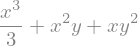

In [6]:
sympy.integrate(expr, x)

Można obliczać pochodne dowolnie wysokiego rzędu - wystarczy podawać kolejne zmienne, po których chcemy różniczkować (lub wskazywać liczbę różniczkowań po danej zmiennej):

In [7]:
sympy.diff(sympy.exp(x * y), x, x)

In [8]:
sympy.diff(sympy.exp(x * y), x, 2, y)

Różniczkowanie (i całkowanie) można wywołać także jako metodę danego wyrażenia symbolicznego:

In [9]:
sympy.exp(x * y).diff(x)

Można także zapamiętać wyrażenie jako pochodną, ale bez obliczania jej:

In [10]:
deriv = sympy.Derivative(sympy.exp(- x**2), x)

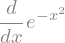

In [11]:
deriv

Analogicznie działa zapisywanie całki (funkcja `Integral`). Wówczas, aby jednak wykonać obliczenia wystarczy metoda `doit`:

In [12]:
deriv.doit()

Na funkcjach (zadeklarowanych symbolicznie) również można wykonywać wymienione wcześniej obliczenia:

In [13]:
t, k, T0, Ta = sympy.symbols('t, k, T_0, T_a')
T = sympy.Function('T')
expr = T(t).diff(t) + k * (T(t) - Ta)

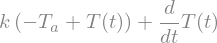

In [14]:
expr

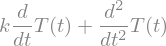

In [15]:
expr.diff(t)

Czasem przydaje się potraktować wyrażenie jako rowność, używając funkcji `Eq` - `SymPy` domyślnie przyrównuje wówczas wyrażenie do zera (jeśli nie podamy *prawej strony*):

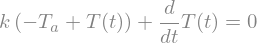

In [16]:
sympy.Eq(expr, 0) 

Możemy też sprawdzić, czy podana funkcja jest rozwiązaniem danego równania, np. wykonując klasyczne podstawienie za pomocą metody `subs`:

In [17]:
sympy.Eq(expr, 0).subs(T(t), Ta + (T0 - Ta) * sympy.exp(- k * t)).doit()

Można też po prostu sprawdzić wartość wyrażenia logicznego (czyli spełnienia równania zapisanego za pomocą `Eq`):

In [18]:
Tsol = Ta + (T0 - Ta) * sympy.exp(- k * t)
sympy.Eq(Tsol.diff(t) + k * (Tsol - Ta), 0)

Jest także możliwość sprawdzenia, czy podana funkcja po podstawieniu do wyrażenia będzie spełniać dane równanie różniczkowe - za pomocą funkcji `checkodesol`:

In [19]:
sympy.checkodesol(expr, Tsol)

(True, 0)

## Równania różniczkowe - rozwiązania symboliczne

Jeśli `SymPy` umie rozwiązać równanie różniczkowe, to robi to za pomocą funkcji `dsolve` (analogicznie jak funkcja `DSolve` w programie *Mathematica*):

In [20]:
ode = T(t).diff(t) + k * (T(t) - Ta)
ode_sol = sympy.dsolve(ode, T(t))
ode_sol

Kilka uwag:
* równanie można podać zarówno jako wyrażenie, wtedy jest przyrównywane do zera, albo jako równość `sympy.Eq(...)`,
* jeśli w równaniu występuje tylko jedna funkcja, to nie trzeba podawać jej jako argumentu.

Funkcja `dsolve` stara się rozpoznać rodzaj równania i znajduje jego **rozwiązanie ogólne**. Warto czasami podejrzeć, jak `dsolve` klasyfikuje dane równanie, wówczas można wskazać metodę rozwiązywania charakterystyczną dla danego typu. Odbywa się to za pomocą funkcji `classify_ode`.

In [21]:
sympy.classify_ode(ode, T(t))

('factorable',
 'separable',
 '1st_exact',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'separable_Integral',
 '1st_exact_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral')

Mając znalezione rozwiązanie ogólne, aby wyświetlić jego wykres, należy po pierwsze podstawić odpowiednie wartości liczbowe parametrów, a po drugie przekształcić wyrażenie z postaci symbolicznej do klasycznej, która może być wyznaczona numerycznie w wielu punktach. Służy do tego funkcja `lambdify`.

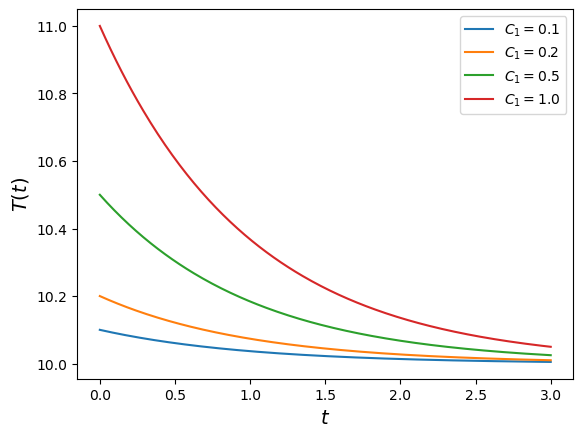

In [22]:
time = np.linspace(0, 3, 250)
for C1 in [0.1, 0.2, 0.5, 1.0]:
    T_C1 = sympy.lambdify(t, ode_sol.rhs.subs({k: 1, Ta: 10, 'C1': C1}), 'numpy')
    plt.plot(time, T_C1(time), label=r"$C_1 = %.1f$" % C1)
    
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$T(t)$", fontsize=14)
plt.legend()
plt.show()

Pozostaje jeszcze kwestia warunków początkowych. Można próbować uwzględniać je ręcznie (rozwiązując odpowiednie równanie), ale można je podać też jako argument funkcji `dsolve` (nie muszą to być konkretne liczby, mogą być parametry - nadal próbujemy rozwiązywać równania symbolicznie) za pomocą parametru `ics` (*initial conditions*):

In [23]:
ivp_sol = sympy.dsolve(ode, T(t), ics={T(0): T0})
ivp_sol

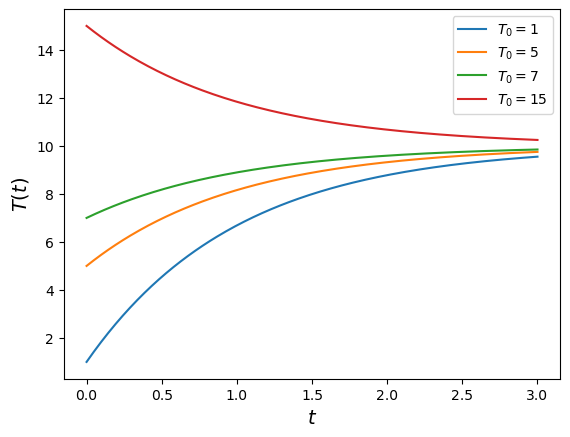

In [25]:
for t0 in [1, 5, 7, 15]:
    T_t = sympy.lambdify(t, ivp_sol.rhs.subs({k: 1, Ta: 10, T0: t0}), 'numpy')
    plt.plot(time, T_t(time), label=r"$T_0 = %.0f$" % t0)
    
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$T(t)$", fontsize=14)
plt.legend()
plt.show()

Powyższy problem był dość trywialny, ale ta sama metoda może zostać użyta właściwie do dowolnego równania zwyczajnego (choć nie ma gwarancji, że rozwiązanie zostanie znalezione). Rozważmy teraz problem:
$$x''(t) + 2p x'(t) + w_0^2 x(t) = 0,$$
czyli problem oscylatora z tłumieniem.

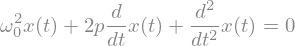

In [26]:
t, omega0, p = sympy.symbols('t, omega_0, p', positive=True)
x = sympy.Function('x')
ode = x(t).diff(t, 2) + 2 * p * x(t).diff(t) + omega0**2 * x(t)
sympy.Eq(ode, 0)

In [27]:
ode_sol = sympy.dsolve(ode, x(t))
ode_sol

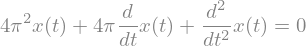

In [28]:
ode = x(t).diff(t, 2) + 4 * sympy.pi * x(t).diff(t) + 4 * sympy.pi**2 * x(t)
sympy.Eq(ode, 0)

In [29]:
ode_sol = sympy.dsolve(ode, x(t))
ode_sol

Widać tutaj jeden z problemów: liczba pod pierwastkiem może być ujemna... W przypadku obliczeń symbolicznych nie zawsze wyniki są wiarygodne. Z równaniami takiego typu jak powyżej (liniowe równanie drugiego rzędu) zapoznamy się na kolejnych zajęciach 

Problemów jest jednak dużo więcej.

## Problemy z rozwiązaniami symbolicznymi

Czasami `SymPy` nie potrafi poradzić sobie z rozwiązaniem równania. Warto tu wyróżnić trzy sytuacje.

1. Rozwiązanie jest zadane w postaci szeregu:

In [30]:
x = sympy.symbols('x')
y = sympy.Function('y')

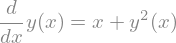

In [31]:
f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

In [32]:
sympy.dsolve(y(x).diff(x) - f, y(x))

TypeError: bad operand type for unary -: 'list'

In [33]:
sympy.classify_ode(y(x).diff(x) - f, y(x))

('1st_rational_riccati', '1st_power_series', 'lie_group')

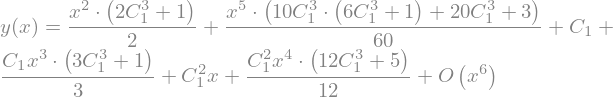

In [34]:
sympy.dsolve(y(x).diff(x) - f, y(x), hint='1st_power_series')

Jak widać - czasami jedna z metod zwraca błędy. Warto wówczas sprawdzić inne metody korzystając z parametru `hint` i podać jako jego wartość inny typ równania (spośród tych zwróconych przez funkcję `classify_ode`).

2. Rozwiązanie zawiera funkcje specjalne:

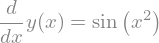

In [35]:
f = sympy.sin(x**2)
sympy.Eq(y(x).diff(x) , f)

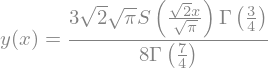

In [36]:
sympy.dsolve(y(x).diff(x) - f, y(x), ics={y(0): 0})

Pojawiła się tajemnicza funkcja $S$ - jest to całka Fresnela, która jest w `SymPy` zdefiniowana... właśnie jako rozwiązanie takiego (analogicznego) równania.

3. `SymPy` po prostu nie potrafi rozwiązać równania:

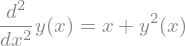

In [37]:
f = y(x)**2 + x
sympy.Eq(y(x).diff(x, 2), f)

In [38]:
sympy.dsolve(y(x).diff(x, 2) - f, y(x))

NotImplementedError: solve: Cannot solve -x - y(x)**2 + Derivative(y(x), (x, 2))

Spróbujemy (nieco później) to równanie rozwiązać numerycznie.

## Pola wektorowe prędkości równań zwyczajnych

Wykres pola wektorowego prędkości (nazywanego również polem kierunków) jest prostym, ale i przydatnym narzędziem wizualizacji możliwych rozwiązań równań zwyczajnych 1. rzędu, zwłaszcza w przypadku równan skalarnych oraz autonomiczych układów dwóch równań skalarnych. Aby je wyznaczyć stworzyć wystarczą podstawowe funkcje z pakietu `matplotlib`. My użyjemy funkcji `quiver`. Każda z takich funkcji wymaga wygenerowania siatki punktów, w których mają zostać zaznaczone odpowiednie wektory, można takie siatki wygenerować automatycznie używając funkcji `meshgrid`.

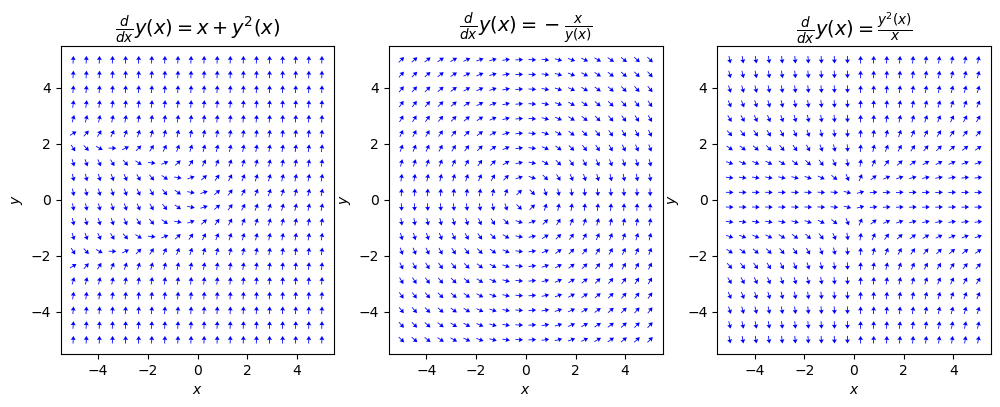

In [41]:
x = sympy.symbols('x')
y = sympy.Function('y')
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# pierwszy przykład
f1 = y(x)**2 + x

f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20, 20))
V = f_np(X, Y)

# normalizacja
Un = U / np.sqrt(U**2 + V**2)
Vn = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[0].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[0].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f1)), fontsize = 14)
axes[0].set_xlabel("$x$", fontsize=10)
axes[0].set_ylabel("$y$", fontsize=10)

# drugi przykład
f2 = -x / y(x)

f_np = sympy.lambdify((x, y(x)), f2, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20, 20))
V = f_np(X, Y)

# normalizacja
Un = U / np.sqrt(U**2 + V**2)
Vn = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[1].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[1].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f2)), fontsize = 14)
axes[1].set_xlabel("$x$", fontsize=10)
axes[1].set_ylabel("$y$", fontsize=10)

# trzeci przykład
f3 = y(x)**2 / x

f_np = sympy.lambdify((x, y(x)), f3, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20, 20))
V = f_np(X, Y)

# normalizacja
Un = U / np.sqrt(U**2 + V**2)
Vn = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[2].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[2].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f3)), fontsize = 14)
axes[2].set_xlabel("$x$", fontsize=10)
axes[2].set_ylabel("$y$", fontsize=10)

plt.show()

Przy okazji możemy sprawdzić jak dobrze radzi sobie `dsolve` w przypadku równań, których rozwiązanie dane jest szeregiem.

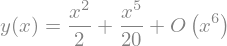

In [42]:
ode_sol = sympy.dsolve(y(x).diff(x) - f1, ics={y(0): 0}, hint='1st_power_series')
ode_sol

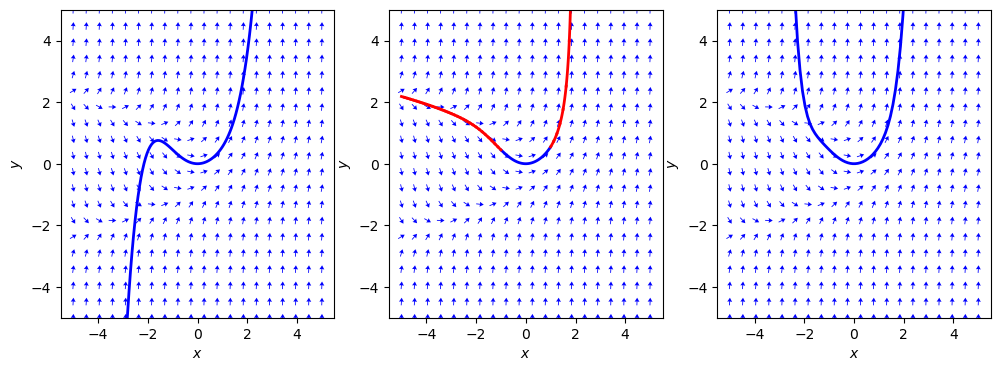

In [43]:
f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# normalizacja
Un = U / np.sqrt(U**2 + V**2)
Vn = V / np.sqrt(U**2 + V**2)

_, axes = plt.subplots(1, 3, figsize=(12,4))
# wyświetlenie pola kierunków
axes[0].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[0].set_xlabel("$x$", fontsize=10);
axes[0].set_ylabel("$y$", fontsize=10);

# wyświetlenie rozwiązania
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

# wyświetlenie pola kierunków
axes[1].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[1].set_xlabel("$x$", fontsize=10);
axes[1].set_ylabel("$y$", fontsize=10);

# wyświetlenie rozwiązania, ale konstruowanego iteracyjnie
x_vec = np.linspace(-1, 1, 100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

ode_sol_1 = ode_sol
for x0 in np.arange(1, 2, 0.125):
    x_vec = np.linspace(x0, x0 + 0.125, 100)
    ode_sol_1 = sympy.dsolve(y(x).diff(x) - f1, ics={y(x0): ode_sol_1.rhs.removeO().subs(x, x0)}, n=6, hint='1st_power_series')
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_1.rhs.removeO())(x_vec), 'r', lw=2)
ode_sol_1 = ode_sol
for x0 in np.arange(1, 5, 0.125):
    x_vec = np.linspace(- x0 - 0.125, - x0, 100)
    ode_sol_1 = sympy.dsolve(y(x).diff(x) - f1, ics={y(-x0): ode_sol_1.rhs.removeO().subs(x, -x0)}, n=6, hint='1st_power_series')
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_1.rhs.removeO())(x_vec), 'r', lw=2)
axes[1].set_ylim(-5, 5)

# wyświetlenie pola kierunków
axes[2].quiver(X, Y, Un, Vn, pivot='mid', headwidth=6, color='blue')
axes[2].set_xlabel("$x$", fontsize=10);
axes[2].set_ylabel("$y$", fontsize=10);

# wyświetlenie rozwiązania, ale obliczonego z większą dokładnością
x_vec = np.linspace(-5, 5, 100)
ode_sol = sympy.dsolve(y(x).diff(x) - f1, ics={y(0): 0}, n=9, hint='1st_power_series')
axes[2].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[2].set_ylim(-5, 5)

plt.show()

Można do zagadnienia pola kierunków podejść też nieco inaczej, tzn. rysując `streamplot`.

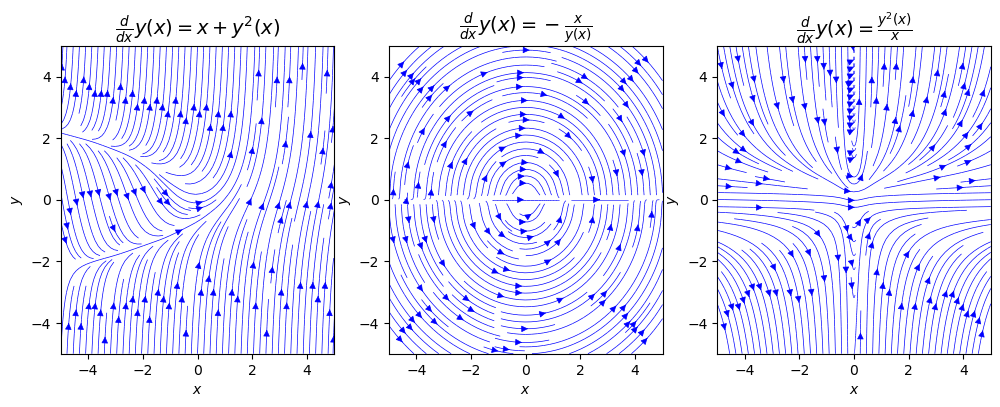

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# pierwszy przykład
f1 = y(x)**2 + x

f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[0].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[0].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f1)), fontsize = 14)
axes[0].set_xlabel("$x$", fontsize=10)
axes[0].set_ylabel("$y$", fontsize=10)

# drugi przykład
f_np = sympy.lambdify((x, y(x)), f2, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[1].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[1].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f2)), fontsize = 14)
axes[1].set_xlabel("$x$", fontsize=10)
axes[1].set_ylabel("$y$", fontsize=10)

# trzeci przykład
f_np = sympy.lambdify((x, y(x)), f3, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[2].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[2].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f3)), fontsize = 14)
axes[2].set_xlabel(r"$x$", fontsize=10)
axes[2].set_ylabel("$y$", fontsize=10)
plt.show()

Na takim wykresie łatwiej zobaczyć rozwiązanie.

## Rozwiązywanie numeryczne

Wiemy już jak rozwiązywać równania zwyczajne symbolicznie (o ile się da), pozostaje jednak problem rozwiązywania numerycznego. Na kolejnych zajęciach pokażemy jak samodzielnie można skonstruować proste metody numeryczne rozwiązujące równania różniczkowe. Są jednak dostępne również wbudowane narzędzia. Odpowiednie funkcje można znaleźć w pakiecie `SciPy` (w module `integrate`) - my posłużymy się funkcją `solve_ivp`, dostępna jest (choć nie jest już polecana) też funkcja `odeint`.

Tym razem nie będziemy się już posługiwać obliczeniami symbolicznymi.

In [46]:
def fun1(x, y):
    "Prawa strona równania y'(x) = y(x)^2 + x"
    dx = y**2 + x
    return dx

Istotna jest tutaj kolejność argumentów podawanych funkcji prawej strony: najpierw zmienna niezależna, potem zmienna zależna (może to być wektor).

In [47]:
ode_sol = integrate.solve_ivp(fun1, [0, 2], [0])

Funkcja `solve_ivp` zwraca strukturę z wieloma różnymi polami zawierającymi m.in. siatkę punktów z przybliżonymi wartościami rozwiązania.

In [48]:
ode_sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  1.000e-04 ...  1.986e+00  1.986e+00]
        y: [[ 0.000e+00  5.000e-09 ...  1.052e+14  1.892e+14]]
      sol: None
 t_events: None
 y_events: None
     nfev: 644
     njev: 0
      nlu: 0

In [49]:
print(ode_sol.t)
print(ode_sol.y[0])

[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.11100000e-01 6.90152577e-01 1.18420544e+00 1.56681729e+00
 1.71204134e+00 1.85726538e+00 1.89398310e+00 1.93070082e+00
 1.95115726e+00 1.96836653e+00 1.97421195e+00 1.98005737e+00
 1.98202062e+00 1.98398388e+00 1.98474786e+00 1.98551184e+00
 1.98575364e+00 1.98599545e+00 1.98609727e+00 1.98619910e+00
 1.98622777e+00 1.98625643e+00 1.98627044e+00 1.98628445e+00
 1.98628758e+00 1.98629070e+00 1.98629270e+00 1.98629425e+00
 1.98629483e+00 1.98629540e+00 1.98629556e+00 1.98629571e+00
 1.98629579e+00 1.98629586e+00 1.98629589e+00 1.98629591e+00
 1.98629592e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.986295

Warto zwrócić tutaj uwagę na trzy rzeczy: 
* `solve_ivp` automatycznie wybiera sobie punkty, w których daje rozwiązanie,
* zawsze podajemy warunek początkowy na początku przedziału (choć możemy też rozwiązywać równanie "do tyłu"),
* `ode_sol.y` to wektor - w przypadku układów równań dostaniemy kolejne współrzędne rozwiązania.

Możemy wymusić, w jakich punktach mamy otrzymać rozwiązanie (używając parametru `t_eval`), możemy też wymóc zwrócenie rozwiązania "ciągłego" (za pomocą parametru `dense_output`).

In [53]:
x_p = np.linspace(0, 1.9, 200)
ode_sol_p = integrate.solve_ivp(fun1, [0, 1.9], [-1], t_eval=x_p)

In [58]:
x_m = np.linspace(0, -1, 200)
ode_sol_m = integrate.solve_ivp(fun1, [0, -1], [-1], t_eval=x_m)

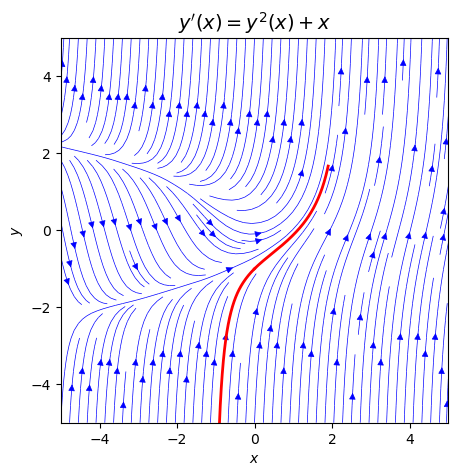

In [59]:
_, axes = plt.subplots(figsize=(5, 5))

x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = Y**2 + X

# wyświetlenie wykresu
axes.streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes.plot(x_p, ode_sol_p.y[0], 'r', lw=2)
axes.plot(x_m, ode_sol_m.y[0], 'r', lw=2)
axes.set_title("$y'(x) = y^2(x) + x$", fontsize = 14)
axes.set_xlabel("$x$", fontsize=10)
axes.set_ylabel("$y$", fontsize=10)
axes.set_xlim(-5, 5)
axes.set_ylim(-5, 5)

plt.show()

In [60]:
ode_sol_c = integrate.solve_ivp(fun1, [0, 1.9], [0], dense_output=True)

Wówczas struktura z rozwiązaniem zawiera dodatkowe pole `sol`, które jest funkcją (interpolowaną) przybliżającą rozwiązanie podanego równania.

In [61]:
ode_sol_c

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             6.902e-01  1.184e+00  1.567e+00  1.736e+00  1.853e+00
             1.900e+00]
        y: [[ 0.000e+00  5.000e-09  6.050e-07  6.161e-05  6.172e-03
              2.463e-01  8.483e-01  2.145e+00  3.845e+00  7.411e+00
              1.153e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000014630D8B550>
 t_events: None
 y_events: None
     nfev: 86
     njev: 0
      nlu: 0

In [63]:
print(ode_sol_c.t)
print(ode_sol_c.y[0])

[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.11100000e-01 6.90152577e-01 1.18420544e+00 1.56681729e+00
 1.73606624e+00 1.85289797e+00 1.90000000e+00]
[0.00000000e+00 5.00000000e-09 6.05000000e-07 6.16050084e-05
 6.17245147e-03 2.46315919e-01 8.48252172e-01 2.14495073e+00
 3.84467498e+00 7.41128470e+00 1.15302416e+01]


In [64]:
ode_sol_c.sol(1.3)[0]

Gdy funkcja ma zwrócić jako wynik funkcję ciągłą (czyli interpolowaną), to nie trzeba już podawać punktów, w których ma zostać znalezione rozwiązanie.

## Własne metody rozwiązywania równań

Domyślnie funkcja `solve_ivp` używa metody rzędu 4 (co oznacza, że błąd zmniejsza się proporcjonalnie do czwartej potęgi długości kroku. Można jednak wykorzystać też własne metody (więcej szczegółów na kolejnych zajęciach) - implementując odpowiednie klasy dziedziczące po `OdeSolver`.

Zrobimy jednak pewne uproszczenia:
* pominiemy możliwość zadawania własnej siatki (tzn. parametru `t_eval`) lub znajdowania rozwiązania interpolowanego (czyli opcji `dense_output=True`) - za to będziemy zawsze podawać krok startowy, z jakim metoda będzie wykonywać obliczenia,
* nie będziemy zajmować się metodami niejawnymi.

Zacznijmy od **metody Eulera**:
$$x_{n+1} = x_n + h\cdot f_n.$$
Jest to najprostsza metoda numeryczna, użyteczna z teoretycznego punktu widzenia, ale nie do końca przydatna w praktyce.

In [ ]:
def euler_step(fun, t, y, h):
    """
    Pojedynczy krok w metodzie Eulera.
    
    Parametry
    ----------
    fun : obiekt wywoływalny (callable)
        Prawa strona układu równań.
    t : float
        Aktualny krok czasowy.
    y : ndarray, wymiaru (n,)
        Aktualna wartość rozwiązania.
    h : float
        Krok czasowy.
    
    Zwraca
    -------
    y_new : ndarray, wymiaru (n,)
        Rozwiązanie przybliżone w punkcie t + h.
    """
    y_new = y + h * fun(t, y)
    return y_new

W następnym kroku musimy zaimplementować klasę, która zawiera tę metodę. Dziedziczy ona po klasie `OdeSolver` i musi zawierać kilka obowiązkowych elementów.

In [ ]:
class Euler(integrate.OdeSolver):
    """
    Stałokrokowa otwarta metoda Eulera (rzędu 1).
    
    (parametry i atrybuty jak w metodach zaimplementowanych w pakiecie `SciPy`.)
    """
    def __init__(self, fun, t0, y0, t_bound, max_step=np.inf, 
                 rtol=1e-3, atol=1e-6, vectorized=False,
                 first_step=None, **extraneous):
        integrate._ivp.common.warn_extraneous(extraneous)
        super(Euler, self).__init__(fun, t0, y0, t_bound, vectorized, 
                                    support_complex=True)
        self.y_old = None
        self.t0 = t0
        self.max_step = integrate._ivp.common.validate_max_step(max_step)
        self.error_estimator_order = 1
        self.rtol, self.atol = integrate._ivp.common.validate_tol(rtol, atol, self.n)
        self.f = self.fun(self.t, self.y)
        if first_step is None:
            self.h_abs = integrate._ivp.common.select_initial_step(
                self.fun, self.t, self.y, self.f, self.direction,
                self.error_estimator_order, self.rtol, self.atol)
        else:
            self.h_abs = integrate._ivp.common.validate_first_step(first_step, t0, t_bound)

    def _step_impl(self):
        # DO UZUPEŁNIENIA

        return True, None
    
    def _dense_output_impl(self):
        return None

Do przetestowania tej funkcji wykorzystamy tzw. model dwóch ciał - dwie masy ($M_1$ i $M_2$) oddziałują na siebie grawitacyjnie i poruszają się. Można pokazać, że środek masy takiego układu porusza się ruchem jednostajnym, można więc przyjąć go jako punkt odniesienia. Aby znaleźć trajektorie ruchu obu mas wystarczy rozwiązać układ dwóch równań: \begin{align*}
r_x''(t) &= - G\frac{r_x(t)}{(r_x^2(t) + r_y^2(t))^{3/2}}, &\quad &r_x(0) = r_{x0},\, r_x'(0) = v_{x0}, \\
r_y''(t) &= - G\frac{r_y(t)}{(r_x^2(t) + r_y^2(t))^{3/2}}, &\quad &r_y(0) = r_{y0},\, r_y'(0) = v_{y0},
\end{align*} a wówczas ruch mas $M_1$ i $M_2$ wokół środka masy jest dany, kolejno, wzorem:
$$R_1(t) = \frac{M_2}{M_1+M_2}(r_x(t), r_y(t)), \quad
R_2(t) = \frac{-M_1}{M_1+M_2}(r_x(t), r_y(t)).$$
Przyjmiemy dla uproszczenia, że $M_1+M_2=1$ oraz $G=1$.

In [ ]:
def TwoBodies(t, R):
    """
    Prawa strona układu równań opisującego model dwóch ciał
    (przy założeniu, że M1+M2=1 oraz G=1)
    """
    R0, R1 = R[2], R[3]
    R2, R3 = - R[0] / np.sqrt(R[0]**2 + R[1]**2)**3, - R[1] / np.sqrt(R[0]**2 + R[1]**2)**3
    return [R0, R1, R2, R3]

Aby sprawdzić działanie zaimplementowanej metody, powinniśmy ją porównać z jakąś metodą referencyjną. Użyjemy do tego metody `'DOP853'` dostępnej w `solve_ivp`.

In [ ]:
M1, M2 = 0.05, 0.95
R0 = 0.95 / M2, 0, 0, 0.6 / M2

tspan = [0, 20]
h = 0.01
sol_euler = integrate.solve_ivp(TwoBodies, tspan, R0, method=Euler, first_step=h)
sol_true = integrate.solve_ivp(TwoBodies, tspan, R0, method='DOP853', dense_output=True, rtol=1e-6, atol=1e-9)

In [ ]:
_, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].plot(sol_euler.t, M2 * sol_euler.y[0], 'b', label="metoda Eulera")
axes[0,0].plot(sol_euler.t, M2 * sol_true.sol(sol_euler.t)[0], 'r', label="rozwiązanie referencyjne")
axes[0,0].set_xlabel("$t$")
axes[0,0].set_ylabel("$R_{1,x}$")
axes[0,0].legend()

axes[0,1].plot(sol_euler.t, M2 * sol_euler.y[1], 'b', label="metoda Eulera")
axes[0,1].plot(sol_euler.t, M2 * sol_true.sol(sol_euler.t)[1], 'r', label="rozwiązanie referencyjne")
axes[0,1].set_xlabel("$t$")
axes[0,1].set_ylabel("$R_{1,y}$")
axes[0,1].legend()

axes[1,0].plot(sol_euler.t, - M1 * sol_euler.y[0], 'b', label="metoda Eulera")
axes[1,0].plot(sol_euler.t, - M1 * sol_true.sol(sol_euler.t)[0], 'r', label="rozwiązanie referencyjne")
axes[1,0].set_xlabel("$t$")
axes[1,0].set_ylabel("$R_{2,x}$")
axes[1,0].legend()

axes[1,1].plot(sol_euler.t, - M1 * sol_euler.y[1], 'b', label="metoda Eulera")
axes[1,1].plot(sol_euler.t, - M1 * sol_true.sol(sol_euler.t)[1], 'r', label="rozwiązanie referencyjne")
axes[1,1].set_xlabel("$t$")
axes[1,1].set_ylabel("$R_{2,y}$")
axes[1,1].legend()

plt.show()

Widzimy, że nawet przy zmniejszaniu długości kroku metoda nie jest zbyt dobra (choć błąd zmniejsza się).

Zobaczmy, jak poradzi sobie inna z metod - **2-krokowa metoda Adamsa-Bashfortha**:
$$x_{n+2} = x_{n+1} + \frac{1}{2}h(3f_{n+1} - f_n).$$
Jest to metoda rzędu 2.

In [ ]:
def ab2_step(fun, t0, t1, x0, x1, h):
    """
    Pojedynczy krok w dwukrokowej metodzie Adamsa-Bashfortha.
    
    Parametry
    ----------
    fun : obiekt wywoływalny (callable)
        Prawa strona układu równań.
    t0 : float
        Krok czasowy t_n.
    t1 : float
        Krok czasowy t_(n+1)
    x0 : ndarray, wymiaru (d,)
        Wartość przybliżenia x_n.
    x1 : ndarray, wymiaru (d,)
        Wartość przybliżenia x_(n+1)
    h : float
        Krok czasowy.
    
    Zwraca
    -------
    x_new : ndarray, wymiaru (d,)
        Rozwiązanie przybliżone w punkcie t_(n+2).
    """
    x_new = x1 + 0.5 * h * (3 * fun(t1, x1) - fun(t0, x0))
    return x_new

In [ ]:
class AB2(integrate.OdeSolver):
    """
    Stałokrokowa 2-krokowa metoda Adamsa-Bashfortha (rzędu 2).
    
    (parametry i atrybuty jak w metodach zaimplementowanych w pakiecie `SciPy`.)
    """
    def __init__(self, fun, t0, y0, t_bound, max_step=np.inf, 
                 rtol=1e-3, atol=1e-6, vectorized=False,
                 first_step=None, **extraneous):
        integrate._ivp.common.warn_extraneous(extraneous)
        super(AB2, self).__init__(fun, t0, y0, t_bound, vectorized, 
                                    support_complex=True)
        self.y_old0 = None
        self.y_old1 = None
        self.t_old0 = None
        self.t_old1 = None
        self.t0 = t0
        self.max_step = integrate._ivp.common.validate_max_step(max_step)
        self.error_estimator_order = 2
        self.rtol, self.atol = integrate._ivp.common.validate_tol(rtol, atol, self.n)
        self.f = self.fun(self.t, self.y)
        if first_step is None:
            self.h_abs = integrate._ivp.common.select_initial_step(
                self.fun, self.t, self.y, self.f, self.direction,
                self.error_estimator_order, self.rtol, self.atol)
        else:
            self.h_abs = integrate._ivp.common.validate_first_step(first_step, t0, t_bound)

    def _step_impl(self):
        # DO UZUPEŁNIENIA

        return True, None
    
    def _dense_output_impl(self):
        return None

In [ ]:
sol_ab2 = integrate.solve_ivp(TwoBodies, tspan, R0, method=AB2, first_step=h)

_, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].plot(sol_ab2.t, M2 * sol_ab2.y[0], 'b', label="metoda AB2")
axes[0,0].plot(sol_ab2.t, M2 * sol_true.sol(sol_ab2.t)[0], 'r', label="rozwiązanie referencyjne")
axes[0,0].set_xlabel("$t$")
axes[0,0].set_ylabel("$R_{1,x}$")
axes[0,0].legend()

axes[0,1].plot(sol_ab2.t, M2 * sol_ab2.y[1], 'b', label="metoda AB2")
axes[0,1].plot(sol_ab2.t, M2 * sol_true.sol(sol_ab2.t)[1], 'r', label="rozwiązanie referencyjne")
axes[0,1].set_xlabel("$t$")
axes[0,1].set_ylabel("$R_{1,y}$")
axes[0,1].legend()

axes[1,0].plot(sol_ab2.t, - M1 * sol_ab2.y[0], 'b', label="metoda AB2")
axes[1,0].plot(sol_ab2.t, - M1 * sol_true.sol(sol_ab2.t)[0], 'r', label="rozwiązanie referencyjne")
axes[1,0].set_xlabel("$t$")
axes[1,0].set_ylabel("$R_{2,x}$")
axes[1,0].legend()

axes[1,1].plot(sol_ab2.t, - M1 * sol_ab2.y[1], 'b', label="metoda AB2")
axes[1,1].plot(sol_ab2.t, - M1 * sol_true.sol(sol_ab2.t)[1], 'r', label="rozwiązanie referencyjne")
axes[1,1].set_xlabel("$t$")
axes[1,1].set_ylabel("$R_{2,y}$")
axes[1,1].legend()

plt.show()

Metoda ta radzi sobie dużo lepiej niż metoda Eulera (co jest zgodne z oczekiwaniami). Nadal jednak widać, że rozwiązania nie są idealne, co jest związane z wieloma różnymi czynnikami.

## Co jeszcze można poprawić?

Poruszyliśmy jedynie podstawowe aspekty konstruowania metod numerycznych dla równań różniczkowych. Można znacznie poprawić osiągnięte wyniki stosując metody wyższych rzędów (niekoniecznie liniowe, np. metody Rungego-Kutty) albo adaptacyjnie dobierając krok całkowania (np. stosując metodę predyktor-korektor).

## Inne pakiety w Pythonie

Nie tylko pakiet `SciPy` zawiera funkcje rozwiązujące równania różniczkowe zwyczajne. Analogiczne narzędzia są też dostępne w innych popularnych pakietach, np. w `TensorFlow Probability` (funkcja `math.ode.DormandPrince` i inne), w `PyTorch` (funkcja `torchdiffeq.odeint`), czy `TensorFlow` (`tfdiffeq`, która duplikuje `torchdiffeq`).

## PRACA DOMOWA

Pracę domową (**pojedynczy plik** notatnika z rozszerzeniem .ipynb) należy przesłać za pośrednictwem platformy *MS Teams* (moduł Zadania) do poniedziałku **10 listopada 2025 roku do godziny 9:00**. Przesłanie rozwiązania po terminie skutkuje otrzymaniem 0 punktów za tę pracę domową.

**D1** (*2 punkty*). Rozważmy układ równań Lotki-Volterry (czyli model drapieżnik-ofiara):
$$x' = ax - bxy, \qquad y' = dxy - cy,$$
gdzie $x$ to liczność populacji ofiary, $y$ to liczność populacji drapieżnika. Stwórz pole kierunków i sprawdź, czy możliwe jest symboliczne wyznaczenie rozwiązania tego problemu dla następujących danych:
$$ a = 0{,}4,\quad b = 0{,}002,\quad c = 0{,}7,\quad d = 0{,}001,\quad x(0) = 600,\quad y(0) = 400.$$

**D2** (*2 punkty*). Rozwiąż numerycznie (korzystając z domyślnej wbudowanej metody) układ równań Lotki-Volterry z zadania **D1**, następnie stwórz wykres rozwiązań (zależności $x(t)$ i $y(t)$), a także nanieś na pole kierunków trajektorię rozwiązania.